In [670]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import plotly.graph_objects as go
from matplotlib import font_manager,rc

get_ipython().run_line_magic('matplotlib','inline')
# %matplotlib inline

path = 'C:/Windows/Fonts/malgun.ttf'

if platform.system() == 'Darwin':
    rc('font',family='Arial Unicode MS')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font',family=font_name)
else:
    print('Unknown system, sorry~')

from sklearn.decomposition import PCA

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [671]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# 한국어 설정
from matplotlib import font_manager, rc
rc("font",family ='Malgun Gothic')
%matplotlib inline

In [672]:
# 엑셀 파일을 읽어옵니다.
df = pd.read_excel('../data/file/imdb_final_6.xlsx', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 905 entries, 0 to 904
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   korean_title        905 non-null    object 
 1   english_title       905 non-null    object 
 2   year                905 non-null    int64  
 3   total_season_num    905 non-null    int64  
 4   runtime             905 non-null    int64  
 5   genre               905 non-null    object 
 6   age_rating          905 non-null    object 
 7   production_country  905 non-null    object 
 8   total_count         905 non-null    int64  
 9   total_rate          905 non-null    float64
 10  watchlist           905 non-null    int64  
 11  popularity          905 non-null    int64  
 12  user_review         905 non-null    int64  
 13  critic_review       905 non-null    int64  
 14  production          821 non-null    object 
 15  distributor         897 non-null    object 
 16  season_1     

In [673]:
# 문자열을 리스트로 변환하는 함수
def parseStringToList(string):
    if pd.isna(string):  # NaN 값인 경우 빈 리스트 반환
        return None
    # 문자열에서 각 요소를 구분하는 쉼표로 분할
    elements = string.split(', ')
    # 각 요소에서 양쪽의 작은따옴표 제거
    elements = [element.strip("['").strip("']") for element in elements]
    return elements
# 'production','distributor' 컬럼의 값을 변환
df['production'] = df['production'].apply(parseStringToList)
df['distributor'] = df['distributor'].apply(parseStringToList)

In [674]:
import ast

# 문자열을 딕셔너리로 변환하는 함수
def preprocess_data(data_str):
    try:
        data_dict = ast.literal_eval(data_str)
        if not data_dict:  # 빈 딕셔너리인 경우
            return None
        else:
            return data_dict
    except (ValueError, SyntaxError):
        return None  # 오류 발생 시 None 반환
    
# # season_으로 시작하는 컬럼에 대해서만 변환 적용
# for column in df_im.columns:
#     if column.startswith('season_'):
#         df_im[column] = df_im[column].apply(preprocess_data)

df['season_1'] = df['season_1'].apply(preprocess_data)

In [675]:
# season_1에 대한 평균 계산
season_1 = df['season_1']

# 평균 rating 계산
avg_rating_season_1 = season_1.apply(
    lambda x: np.mean([ep[0] for ep in x.values()]) if x else None
)

# 평균 views 계산
avg_views_season_1 = season_1.apply(
    lambda x: np.mean([ep[1] for ep in x.values()]) if x else None
)

In [676]:
# df_im에 s1_avg_rating, s1_avg_views 컬럼 추가
df['s1_avg_rating'] = avg_rating_season_1
df['s1_avg_views'] = avg_views_season_1

In [677]:
# 시청 지속율(관심유지도) 계산 함수
def calculate_retention_rate(season_data):
    episode_views = [ep[1] for ep in season_data.values() if isinstance(ep, (list, tuple))]
    if len(episode_views) > 1:
        initial_viewers = episode_views[0]
        final_viewers = episode_views[-1]
        retention_rate = (final_viewers / initial_viewers) * 100
    else:
        retention_rate = 100  # If there's only one episode, retention is 100%
    return retention_rate

# 시즌 1의 시청 지속율 계산
df['s1_retention_rate'] = df['season_1'].apply(calculate_retention_rate)

In [678]:
# 'date_of_first' 컬럼 추가
df['date_of_first'] = [next(iter(data_dict.values()))[2] for data_dict in df['season_1']]
# 'date_of_second' 컬럼 추가
df['date_of_second'] = [list(data_dict.values())[1][2] if len(data_dict) > 1 else None for data_dict in df['season_1']]
# 'date_of_last' 컬럼 추가
df['date_of_last'] = [list(data_dict.values())[-1][2] for data_dict in df['season_1']]
# 'term' 컬럼 추가
df['term'] = df.apply(lambda row: 0 if row['date_of_last'] == row['date_of_first'] else (1 if row['date_of_first'] == row['date_of_second'] else 2), axis=1)

# 결과 확인
print(df[['season_1', 'date_of_first', 'date_of_second', 'date_of_last', 'term']])

                                                     season_1  \
Unnamed: 0                                                      
0           {'S1.E1': [8.2, 16000, 'Fri, Sep 17, 2021'], '...   
1           {'S1.E1': [7.3, 224, 'Sun, Nov 3, 2019'], 'S1....   
2           {'S1.E1': [7.4, 62, 'Thu, Apr 30, 2020'], 'S1....   
3           {'S1.E1': [7.9, 2500, 'Fri, Jun 4, 2021'], 'S1...   
4           {'S1.E1': [7.1, 1100, 'Fri, Dec 18, 2020'], 'S...   
...                                                       ...   
900         {'S1.E1': [5.6, 322, 'Fri, Jun 14, 2019'], 'S1...   
901         {'S1.E1': [7.6, 148, 'Fri, Apr 14, 2017'], 'S1...   
902         {'S1.E1': [5.8, 60, 'Fri, Apr 17, 2020'], 'S1....   
903         {'S1.E1': [8.0, 44, 'Thu, Aug 8, 2019'], 'S1.E...   
904         {'S1.E1': [6.5, 225, 'Tue, Jun 15, 2021'], 'S1...   

                date_of_first     date_of_second       date_of_last  term  
Unnamed: 0                                                                 
0 

In [679]:
# 이 컬럼은 여기서 사용하지 않을 예정이라 잠시 뺌
del df['date_of_first']
del df['date_of_second']
del df['date_of_last']

del df['season_1']

In [680]:
# 이 컬럼은 여기서 사용하지 않을 예정이라 잠시 뺌
del df['season_2']
del df['season_3']
del df['season_4']
del df['season_5']
del df['season_6']
del df['season_7']
del df['season_8']
del df['season_9']
del df['season_10']
del df['season_11']
del df['season_12']
del df['season_13']
del df['season_14']
del df['season_15']
del df['season_16']
del df['season_17']

In [681]:
# 이 컬럼은 여기서 사용하지 않을 예정이라 잠시 뺌
del df['year']  # 차라리 term을 넣기

del df['production']
del df['distributor']
del df['director']
del df['writer']
del df['actor']

In [682]:
# 드라마의 전반적인 인기
del df['total_season_num']
del df['total_count']
del df['total_rate']
del df['watchlist']
del df['popularity']

del df['user_review']
del df['critic_review']
del df['wins']
del df['nominations']

del df['imdb_title']
del df['imdb_url']

- 드라마 전반적인 인기도: total_count, total_rate, watchlist, popularity, user_review, critic_review, wins, nominations
- 각 시즌 인기: s1_avg_rating, s1_avg_views, 's1_retention_rate'
- 각 시즌 특징: runtime, genre, age_rating, production_country, 'term'

total_season_num는 전반적인 인기도에 넣으려면 -1하고 넣어야 될듯
year 부분은 교수님 피드백에 따라 넣진 않음

### 인코딩해야하는 컬럼
- 제작사, 배급사
- 감독, 작가, 배우

In [683]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 905 entries, 0 to 904
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   korean_title        905 non-null    object 
 1   english_title       905 non-null    object 
 2   runtime             905 non-null    int64  
 3   genre               905 non-null    object 
 4   age_rating          905 non-null    object 
 5   production_country  905 non-null    object 
 6   s1_avg_rating       905 non-null    float64
 7   s1_avg_views        905 non-null    float64
 8   s1_retention_rate   905 non-null    float64
 9   term                905 non-null    int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 77.8+ KB


In [684]:
# production_country 컬럼의 데이터를 처리하는 함수 정의
def process_countries(countries):
    # 쉼표를 기준으로 분리하고 첫 번째 나라 선택
    countries_list = countries.split(',')
    first_country = countries_list[0].strip()
    return first_country

# apply 함수를 사용하여 모든 행에 적용
df['production_country'] = df['production_country'].apply(process_countries)

## production_country 제작 국가인 경우 일단 첫 나라만 선택 후 TargetEncoder

# 26개 - 처리

In [685]:
import category_encoders as ce

# TargetEncoder 객체 생성 및 fit_transform으로 변환 (count 사용)
target_encoder = ce.TargetEncoder(cols=['production_country'], handle_unknown='count')
df_im_encoded = target_encoder.fit_transform(df['production_country'], df.index)

# 인코딩된 값을 기존 데이터프레임에 추가
df['production_country_encoded'] = df_im_encoded

print(df[['production_country','production_country_encoded']])

           production_country  production_country_encoded
Unnamed: 0                                               
0                        대한민국                  417.181824
1                         벨기에                  443.500502
2                          대만                  509.258276
3                          미국                  299.276018
4                        대한민국                  417.181824
...                       ...                         ...
900                        인도                  659.064601
901                        일본                  513.131229
902                        인도                  659.064601
903                       레바논                  510.678922
904                       스페인                  530.323066

[905 rows x 2 columns]


In [686]:
del df['production_country']

# genre는 핫인코딩 후 pca로 1컬럼으로 만듬..

In [687]:
# 'genre' 컬럼에 대해서만 문자열로 변환
df['genre'] = df['genre'].astype(str)

# '드라마' 항목 제거
df['genre'] = df['genre'].apply(lambda x: ', '.join([genre for genre in x.split(', ') if genre != '드라마']))

In [688]:
df['genre'] = df['genre'].apply(lambda x: x.split(', '))
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genre'])
genre_encoded_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)
df_im = pd.concat([genre_encoded_df, df.drop(columns=['genre'])], axis=1)

In [689]:
# # 장르 분할
# df_im['genre'] = df_im['genre'].str.split(', ')

# # 각 장르를 개별적으로 변환
# all_genres = set([genre for sublist in df_im['genre'] for genre in sublist])
# for genre in all_genres:
#     df_im[genre] = df_im['genre'].apply(lambda x: 1 if genre in x else 0)

# # 'genre' 컬럼 삭제
# df_im = df_im.drop('genre', axis=1)

# print(df_im)

In [690]:
df_im.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0                               905 non-null    int32  
 1   Made in Europe              905 non-null    int32  
 2   SF                          905 non-null    int32  
 3   가족                          905 non-null    int32  
 4   공포                          905 non-null    int32  
 5   로맨스                         905 non-null    int32  
 6   범죄                          905 non-null    int32  
 7   서부                          905 non-null    int32  
 8   스릴러                         905 non-null    int32  
 9   스포츠                         905 non-null    int32  
 10  액션                          905 non-null    int32  
 11  역사                          905 non-null    int32  
 12  음악                          905 non-null    int32  
 13  전쟁                          905 non

In [691]:
numeric_df = df_im.select_dtypes(include=['int32', 'uint8'])  # 'uint8'은 원핫 인코딩된 컬럼의 데이터 타입

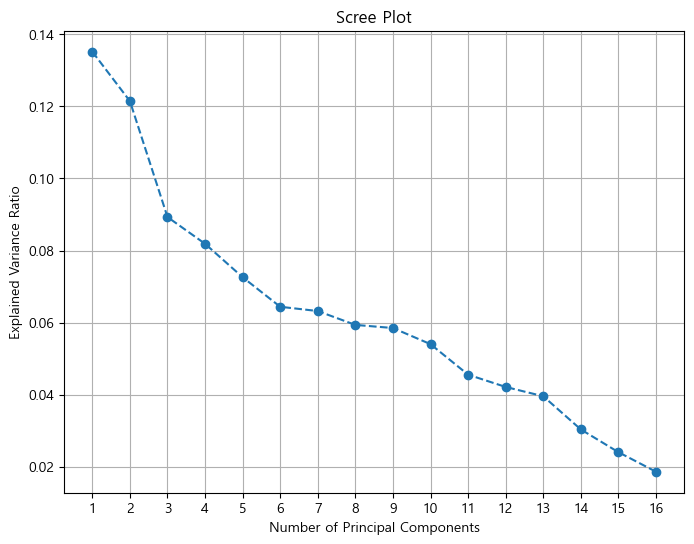

In [692]:
# 데이터 표준화
scaler = StandardScaler()
numeric_df_scaled = scaler.fit_transform(numeric_df)

# PCA 수행
pca = PCA()
pca.fit(numeric_df_scaled)

# Scree Plot 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()

In [693]:
# 설명된 분산 비율 출력
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each principal component:")
for i, var_ratio in enumerate(explained_variance_ratio, start=1):
    print(f"Principal Component {i}: {var_ratio:.4f}")

Explained variance ratio for each principal component:
Principal Component 1: 0.1352
Principal Component 2: 0.1215
Principal Component 3: 0.0893
Principal Component 4: 0.0819
Principal Component 5: 0.0726
Principal Component 6: 0.0644
Principal Component 7: 0.0632
Principal Component 8: 0.0594
Principal Component 9: 0.0585
Principal Component 10: 0.0540
Principal Component 11: 0.0455
Principal Component 12: 0.0421
Principal Component 13: 0.0396
Principal Component 14: 0.0303
Principal Component 15: 0.0240
Principal Component 16: 0.0186


- 다시 PCA하는건 의미 없겠음

In [694]:
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),  # 데이터 스케일링
#     ('pca', PCA(n_components=2))  # PCA 적용 (차원을 2로 축소)
# ])
# # Fit-transform the numeric data
# transformed_data = pipeline.fit_transform(numeric_df)

# # Assign the transformed data to a new column 'genre' in df_im
# df_im['genre'] = transformed_data[:, 0]

In [695]:
df_im['age_rating'] = df_im['age_rating'].replace('ALL', 0).astype(int)

In [696]:
# 이 컬럼은 여기서 사용하지 않을 예정이라 잠시 뺌
del df_im['korean_title']
del df_im['english_title']

In [697]:
# 데이터 표준화
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_im)

# NumPy 배열을 데이터프레임으로 변환
df_scaled_df = pd.DataFrame(df_scaled, columns=df_im.columns)

In [698]:
df_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0                               905 non-null    float64
 1   Made in Europe              905 non-null    float64
 2   SF                          905 non-null    float64
 3   가족                          905 non-null    float64
 4   공포                          905 non-null    float64
 5   로맨스                         905 non-null    float64
 6   범죄                          905 non-null    float64
 7   서부                          905 non-null    float64
 8   스릴러                         905 non-null    float64
 9   스포츠                         905 non-null    float64
 10  액션                          905 non-null    float64
 11  역사                          905 non-null    float64
 12  음악                          905 non-null    float64
 13  전쟁                          905 non

In [699]:
df_scaled_df.head()

,,Made in Europe,SF,가족,공포,로맨스,범죄,서부,스릴러,스포츠,...,전쟁,코미디,판타지,runtime,age_rating,s1_avg_rating,s1_avg_views,s1_retention_rate,term,production_country_encoded
0,-0.30711,-0.150329,-0.501726,-0.209354,-0.300602,-0.563313,-0.645194,-0.074536,1.250496,-0.115922,...,-0.181948,-0.686691,-0.404029,0.549457,0.761370,0.591974,4.424240,0.506751,-0.885018,-0.148134
1,-0.30711,-0.150329,-0.501726,-0.209354,-0.300602,-0.563313,-0.645194,-0.074536,1.250496,-0.115922,...,-0.181948,-0.686691,-0.404029,0.476886,0.761370,-0.346513,-0.239082,0.177364,1.181927,0.128248
2,-0.30711,-0.150329,-0.501726,-0.209354,-0.300602,-0.563313,1.549921,-0.074536,1.250496,-0.115922,...,-0.181948,-0.686691,-0.404029,0.912314,0.761370,0.263870,-0.279981,0.553726,-0.885018,0.818796
3,-0.30711,-0.150329,1.993120,-0.209354,-0.300602,-0.563313,-0.645194,-0.074536,-0.799683,-0.115922,...,-0.181948,-0.686691,2.475073,0.331743,-0.611903,0.461832,0.321216,0.215503,-0.885018,-1.386308
4,-0.30711,-0.150329,1.993120,-0.209354,3.326660,-0.563313,1.549921,-0.074536,1.250496,-0.115922,...,-0.181948,-0.686691,2.475073,0.912314,0.761370,-0.320118,-0.027381,-0.010434,-0.885018,-0.148134


In [700]:
df_scaled_df = df_scaled_df[['runtime','age_rating','s1_avg_rating','s1_avg_views','s1_retention_rate','term','production_country_encoded']]

In [701]:
# 군집수에 따른 실루엣계수를 담을 리스트
silhouette_scores = []

# 2~10까지 군집수를 변화시키며 실루엣계수를 계산
for n_clusters in range(2, 16):
    # KMeans 군집화 수행
    kmeans = KMeans(n_clusters=n_clusters, random_state=13)
    kmeans.fit(df_scaled_df)

    # 실루엣계수 계산
    silhouette_score_ = silhouette_score(df_scaled_df, kmeans.labels_)
    silhouette_scores.append(silhouette_score_)


c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by set

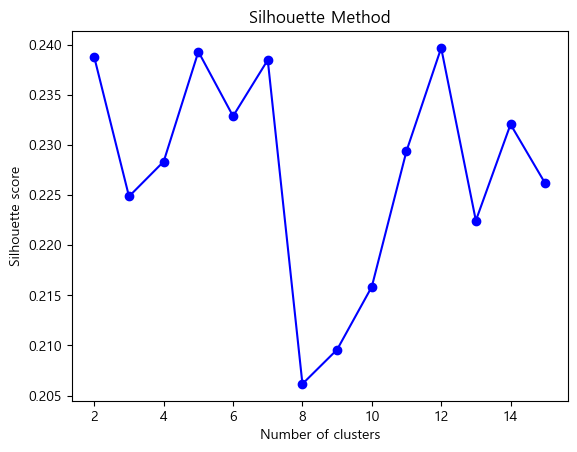

In [702]:
# 군집수에 따른 실루엣계수 그래프 그리기
plt.plot(range(2, 16), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.show()

# 실루엣계수Score가 너무 작아 의미가 없을 수도! 교수님한테 물어보기

In [703]:
# df_scaled_df = df_scaled_df[['runtime','age_rating','s1_avg_rating','s1_avg_views','s1_retention_rate','term','production_country_encoded']]

In [704]:
from sklearn.cluster import KMeans
import plotly.graph_objects as go

# KMeans 군집화
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled_df)

# 군집 레이블을 기준으로 데이터프레임에 추가
df_scaled_df['cluster'] = cluster_labels

# 클러스터별로 데이터 분리
clusters = []
for i in range(5):
    clusters.append(df_scaled_df[df_scaled_df['cluster'] == i])

# Plotly를 사용하여 시각화
fig = go.Figure()

# 각 군집에 대한 산점도 추가
# 12개의 고유한 색상을 설정
colors = [
    'blue', 'red', 'green', 'orange', 'purple'
]

for i, cluster in enumerate(clusters):
    fig.add_trace(go.Scatter(
        x=cluster['s1_avg_rating'],  # 실제 데이터셋에서 사용하는 특성 이름으로 변경 
        y=cluster['s1_avg_views'],  # 실제 데이터셋에서 사용하는 특성 이름으로 변경 
        mode='markers', 
        marker=dict(color=colors[i]), 
        name=f'Cluster {i}'
    ))

fig.show()


c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



### 군집3번 뭐하나가 이상하다 -> 이상치?

In [705]:
import plotly.graph_objects as go

# Create a list of variable names
variable_names = ['runtime', 'age_rating', 's1_avg_rating', 's1_avg_views', 's1_retention_rate', 'term', 'production_country_encoded']

# Define colors for each cluster
colors = ['blue', 'red', 'green', 'orange', 'purple']

# Loop through each variable and create a scatter plot for each cluster
for variable in variable_names:
    # Create an empty figure
    fig = go.Figure()

    # Loop through each cluster
    for i in range(5):  # 클러스터 개수에 맞게 수정 (여기서는 5개의 클러스터를 가정)
        # Filter data for the current cluster
        cluster_data = df_scaled_df[df_scaled_df['cluster'] == i]

        # Add scatter trace for the current cluster and variable
        fig.add_trace(go.Scatter(
            x=cluster_data[variable],
            y=cluster_data['s1_avg_rating'],
            mode='markers',
            marker=dict(color=colors[i]),
            name=f'Cluster {i}'
        ))

    # Set layout for the plot
    fig.update_layout(
        title=f"Scatter Plot of {variable} vs s1_avg_rating",
        xaxis=dict(title=variable),
        yaxis=dict(title='s1_avg_rating')
    )

    # Show plot
    fig.show()


### 여기서 한점씩 보이는 것이 이상치인가?

In [706]:
# 각 클러스터의 중심값 출력
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=df.columns[:-1])  # 마지막 'cluster' 열 제외

print("각 클러스터의 중심값:")
print(cluster_centers_df)

ValueError: operands could not be broadcast together with shapes (5,7) (23,) (5,7) 

In [ ]:
# 군집 중심 좌표
kmeans.cluster_centers_

# 군집 중심 좌표를 DataFrame으로 변환
cluster_center_df = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

cluster_center_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Made in Europe              905 non-null    int32  
 1   SF                          905 non-null    int32  
 2   가족                          905 non-null    int32  
 3   공포                          905 non-null    int32  
 4   드라마                         905 non-null    int32  
 5   로맨스                         905 non-null    int32  
 6   범죄                          905 non-null    int32  
 7   서부                          905 non-null    int32  
 8   스릴러                         905 non-null    int32  
 9   스포츠                         905 non-null    int32  
 10  액션                          905 non-null    int32  
 11  역사                          905 non-null    int32  
 12  음악                          905 non-null    int32  
 13  전쟁                          905 non

In [ ]:
'''
# 모든 시즌에 대해서 데이터를 변환하고 평균을 계산하는 함수
def process_seasons(df, start_season=1, end_season=17):
    for season_num in range(start_season, end_season + 1):
        season_col = f'season_{season_num}'
        avg_rating_col = f's{season_num}_avg_rating'
        avg_views_col = f's{season_num}_avg_views'
        
        # 평균 계산
        df[avg_rating_col] = df[season_col].apply(
            lambda x: sum([float(ep[0]) for ep in x.values()]) / len(x) if x else None
        )
        df[avg_views_col] = df[season_col].apply(
            lambda x: sum([int(ep[1]) for ep in x.values()]) / len(x) if x else None
        )

# 모든 시즌에 대해 변환 및 평균 계산
process_seasons(df_im)
'''

"\n# 모든 시즌에 대해서 데이터를 변환하고 평균을 계산하는 함수\ndef process_seasons(df, start_season=1, end_season=17):\n    for season_num in range(start_season, end_season + 1):\n        season_col = f'season_{season_num}'\n        avg_rating_col = f's{season_num}_avg_rating'\n        avg_views_col = f's{season_num}_avg_views'\n        \n        # 평균 계산\n        df[avg_rating_col] = df[season_col].apply(\n            lambda x: sum([float(ep[0]) for ep in x.values()]) / len(x) if x else None\n        )\n        df[avg_views_col] = df[season_col].apply(\n            lambda x: sum([int(ep[1]) for ep in x.values()]) / len(x) if x else None\n        )\n\n# 모든 시즌에 대해 변환 및 평균 계산\nprocess_seasons(df_im)\n"

---

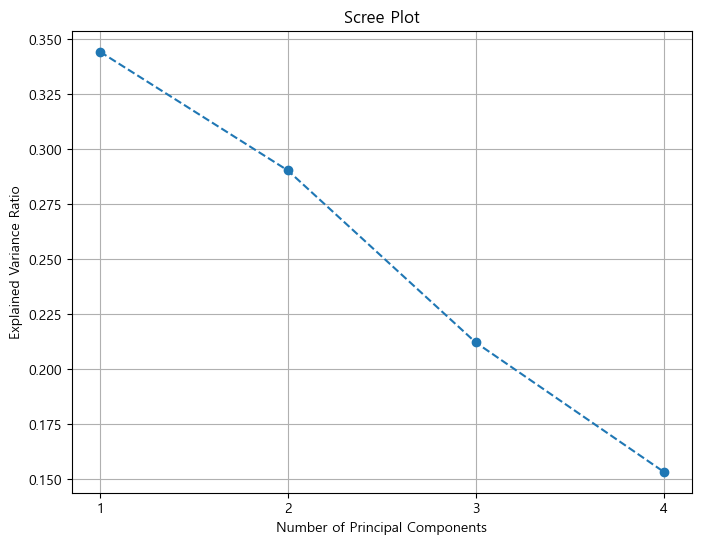

In [ ]:
# PCA를 위한 데이터 준비
metrics_df = pd.DataFrame()
metrics_df['s1_avg_rating'] = df_im['s1_avg_rating']
metrics_df['s1_avg_views'] = df_im['s1_avg_views']
metrics_df['s1_retention_rate'] = df_im['s1_retention_rate']
metrics_df['term'] = df_im['term']
# 데이터 표준화
scaler = StandardScaler()
metrics_df_scaled = scaler.fit_transform(metrics_df)

# PCA 수행
pca = PCA()
pca.fit(metrics_df_scaled)

# Scree Plot 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()

In [ ]:
# 설명된 분산 비율 출력
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each principal component:")
for i, var_ratio in enumerate(explained_variance_ratio, start=1):
    print(f"Principal Component {i}: {var_ratio:.4f}")

Explained variance ratio for each principal component:
Principal Component 1: 0.3442
Principal Component 2: 0.2903
Principal Component 3: 0.2121
Principal Component 4: 0.1534


In [ ]:
# PCA 적용 (n_components=2)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(metrics_df_scaled)

# PCA에서 추출한 주성분 가중치
pca_weights = pca.components_

# 각 주성분에 대한 가중치 딕셔너리
weights_pc1 = {metrics_df.columns[i]: pca_weights[0, i] for i in range(len(metrics_df.columns))}
weights_pc2 = {metrics_df.columns[i]: pca_weights[1, i] for i in range(len(metrics_df.columns))}


print("Weights for PC1:")
print(weights_pc1)

print("Weights for PC2:")
print(weights_pc2)

Weights for PC1:
{'s1_avg_rating': 0.6643121372371482, 's1_avg_views': 0.3435753212843481, 's1_retention_rate': -0.12458381717298767, 'term': 0.6520155331143391}
Weights for PC2:
{'s1_avg_rating': 0.182870740039519, 's1_avg_views': 0.5379781032623989, 's1_retention_rate': 0.75581880759632, 'term': -0.325385591154966}


PC1은 s1_avg_rating, s1_avg_views, 그리고 term와 강한 양의 상관관계를 가지며, 이는 이 주성분이 주로 이 변수들에 의해 설명된다는 것을 의미합니다. 반면, s1_retention_rate와는 약한 음의 상관관계를 가집니다.

PC2는 s1_avg_views와 s1_retention_rate와 강한 양의 상관관계를 가지며, 이는 이 주성분이 주로 이 변수들에 의해 설명된다는 것을 의미합니다. s1_avg_rating는 약한 양의 상관관계를 가지며, term은 약한 음의 상관관계를 가집니다.

결론:
PC1은 주로 s1_avg_rating, s1_avg_views, term에 의해 정의되며, 이를 통해 각 변수의 중요한 역할을 확인할 수 있습니다.
PC2는 주로 s1_avg_views와 s1_retention_rate에 의해 정의되며, 이 변수들이 데이터의 또 다른 중요한 패턴을 설명하는데 기여합니다.

In [ ]:
# 각 주성분의 가중치 설정 (설명된 분산 비율 사용)
weights = explained_variance_ratio[:3] / explained_variance_ratio[:3].sum()

# 각 주성분에 대한 가중치 출력
print(f"Weights for PC1, PC2: {weights}")

# 가중치 딕셔너리 설정
weights_pc1 = {metrics_df.columns[i]: pca_weights[0, i] for i in range(len(metrics_df.columns))}
weights_pc2 = {metrics_df.columns[i]: pca_weights[1, i] for i in range(len(metrics_df.columns))}

# 흥행지표 계산 함수 수정
def calculate_success_metric(row, weights_pc1, weights_pc2, weights):
    # 각 주성분의 흥행지표 계산
    metric_pc1 = sum(weights_pc1[col] * row[col] for col in metrics_df.columns)
    metric_pc2 = sum(weights_pc2[col] * row[col] for col in metrics_df.columns)
    
    # 종합 흥행지표 계산
    total_metric = weights[0] * metric_pc1 + weights[1] * metric_pc2
    return total_metric

# 종합 흥행지표 계산 및 결과 출력
df_im['success_metric'] = df_im.apply(lambda row: calculate_success_metric(row, weights_pc1, weights_pc2, weights), axis=1)

# 결과 출력
print(df_im[['korean_title', 'success_metric']])

Weights for PC1, PC2: [0.40655654 0.34285852 0.25058494]
                       korean_title  success_metric
Unnamed: 0                                         
0                            오징어 게임     4846.891434
1                          12인의 심판자       78.559431
2                            희생자 게임       38.621859
3                스위트 투스: 사슴뿔을 가진 소년      651.371882
4                              스위트홈      293.642092
...                             ...             ...
900                             레일라      102.909099
901                     100만 엔의 여인들       22.910100
902                         킬러 코미디언       28.259194
903                              달러       27.157194
904         엘리트들, 못다 한 이야기: 나디아 구스만       94.327656

[905 rows x 2 columns]


In [ ]:
# PCA 결과를 데이터프레임에 추가
df_im['PC1'] = principal_components[:, 0]
df_im['PC2'] = principal_components[:, 1]

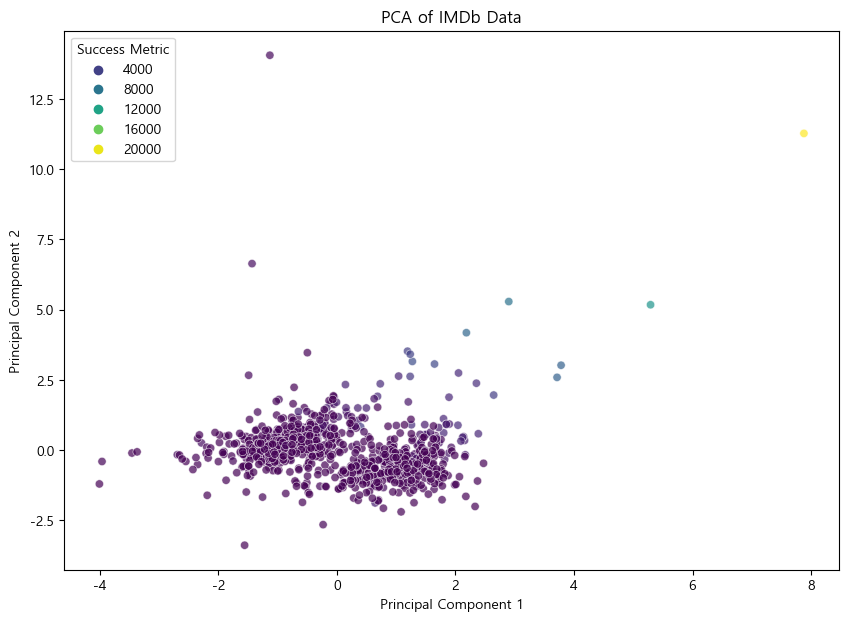

In [ ]:
# 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_im, x='PC1', y='PC2', hue='success_metric', palette='viridis', alpha=0.7)
plt.title('PCA of IMDb Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Success Metric')
plt.show()

                korean_title  success_metric
Unnamed: 0                                  
46                     블랙 미러    20660.969584
17                   브레이킹 배드    10713.811960
24                   기묘한 이야기     7843.485881
31                        위쳐     6827.191659
7                      워킹 데드     6336.252886
42                   베터 콜 사울     6306.795742
0                     오징어 게임     4846.891434
13                        다크     4396.905774
63                       원피스     4076.789711
27                  피키 블라인더스     3748.520928
43                     퀸스 갬빗     3680.605670
196         기예르모 델토로의 호기심의 방     3627.578780
66                 힐 하우스의 유령     3253.862370
54                       덱스터     2615.516009
64                       샌드맨     2606.002281
51                     종이의 집     2467.513745
9                        플래시     2431.382031
735                     패러노멀     2379.291777
20                     마인드헌터     2325.680899
19                      바이킹스     2322.401325
84        

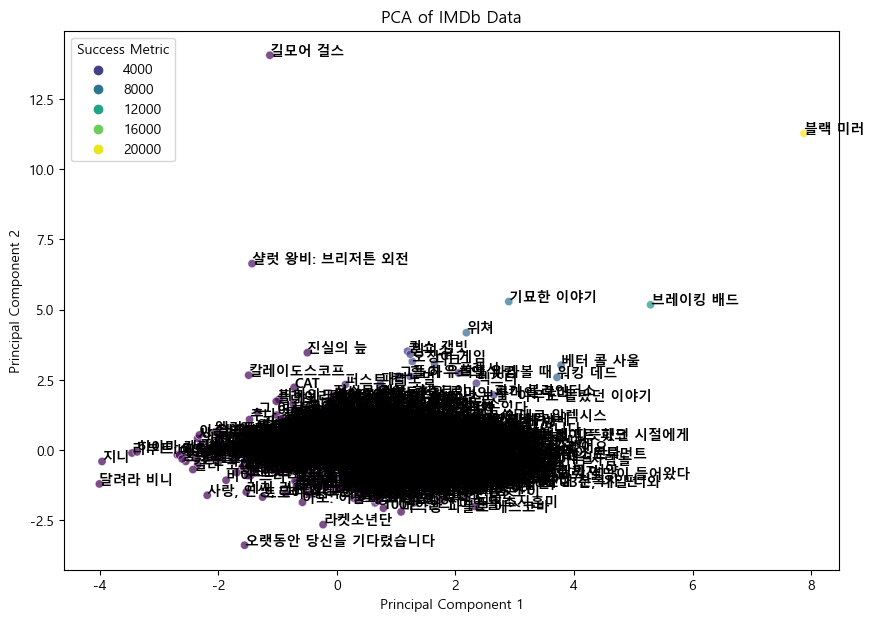

In [ ]:
# success_metric을 기준으로 내림차순 정렬
sorted_df = df_im.sort_values(by='success_metric', ascending=False)

# 상위 30개 작품 출력 (korean_title 사용)
top_30 = sorted_df[['korean_title', 'success_metric']].head(30)

# 결과 출력
print(top_30)

# 시각화
plt.figure(figsize=(10, 7))
scatterplot = sns.scatterplot(data=df_im, x='PC1', y='PC2', hue='success_metric', palette='viridis', alpha=0.7)

# 각 점에 korean_title 표시
for line in range(0, df_im.shape[0]):
    scatterplot.text(df_im.PC1[line], df_im.PC2[line], df_im.korean_title[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title('PCA of IMDb Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Success Metric')
plt.show()

---

In [ ]:
# 엑셀 파일을 읽어옵니다.
df_wat = pd.read_excel('../data/file/watcha.xlsx', index_col=0)
df_wat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 905 entries, 0 to 904
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   korean_title        905 non-null    object 
 1   english_title       905 non-null    object 
 2   year                905 non-null    int64  
 3   total_season_num    905 non-null    int64  
 4   production_country  905 non-null    object 
 5   watcha_name         905 non-null    object 
 6   season_1            905 non-null    object 
 7   season_2            266 non-null    object 
 8   season_3            136 non-null    object 
 9   season_4            79 non-null     object 
 10  season_5            49 non-null     object 
 11  season_6            35 non-null     object 
 12  season_7            21 non-null     object 
 13  season_8            8 non-null      object 
 14  season_9            4 non-null      object 
 15  season_10           2 non-null      object 
 16  season_11    

In [ ]:
# 이 컬럼은 여기서 사용하지 않을 예정이라 잠시 뺌
del df_wat['season_2']
del df_wat['season_3']
del df_wat['season_4']
del df_wat['season_5']
del df_wat['season_6']
del df_wat['season_7']
del df_wat['season_8']
del df_wat['season_9']
del df_wat['season_10']
del df_wat['season_11']
del df_wat['season_12']
del df_wat['season_13']
del df_wat['season_14']
del df_wat['season_15']
del df_wat['season_16']
del df_wat['season_17']

del df_wat['total_season_num']
del df_wat['production_country']
del df_wat['watcha_name']

In [ ]:
# 문자열을 리스트로 변환하는 함수
def parseStringToList(string):
    if pd.isna(string):  # NaN 값인 경우 빈 리스트 반환
        return None
    # 문자열에서 각 요소를 구분하는 쉼표로 분할
    elements = string.split(', ')
    # 각 요소에서 양쪽의 작은따옴표 제거
    elements = [element.strip("['").strip("']") for element in elements]
    return elements

df_wat['season_1'] = df_wat['season_1'].apply(parseStringToList)

In [ ]:
# 'season_1' 열의 첫 번째 값을 추출하고 float으로 변환하여 새로운 열 'w_s1_rate'에 할당
df_wat['w_s1_rate'] = df_wat['season_1'].apply(lambda x: float(x[0]))

In [ ]:
# 'season_1' 열의 첫 번째 값을 추출하고 float으로 변환하여 새로운 열 'w_s1_rate'에 할당
df_wat['w_s1_views'] = df_wat['season_1'].apply(lambda x: int(x[1]))

In [ ]:
# reviews
df_wat['w_s1_reviews'] = df_wat['season_1'].apply(lambda x: int(x[2]))

In [ ]:
df_wat

,korean_title,english_title,year,season_1,w_s1_rate,w_s1_views,w_s1_reviews
0,오징어 게임,Squid Game,2021,"[3.3, 95000, 7500]",3.3,95000,7500
1,12인의 심판자,The Twelve,2019,"[2.8, 55, 6]",2.8,55,6
2,희생자 게임,The Victims' Game,2020,"[3.2, 290, 30]",3.2,290,30
3,스위트 투스: 사슴뿔을 가진 소년,Sweet Tooth,2021,"[3.6, 2860, 250]",3.6,2860,250
4,스위트홈,Sweet Home,2020,"[3.5, 64000, 4000]",3.5,64000,4000
...,...,...,...,...,...,...,...
900,레일라,Leila,2019,"[3.2, 27, 3]",3.2,27,3
901,100만 엔의 여인들,Million Yen Women,2017,"[3.0, 718, 100]",3.0,718,100
902,킬러 코미디언,Hasmukh,2020,"[1.6, 4, 0]",1.6,4,0
903,달러,Dollar,2019,"[0.7, 3, 1]",0.7,3,1


df = pd.merge(df_im, df_wat, on=['korean_title','english_title'], how='left')
df.info()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


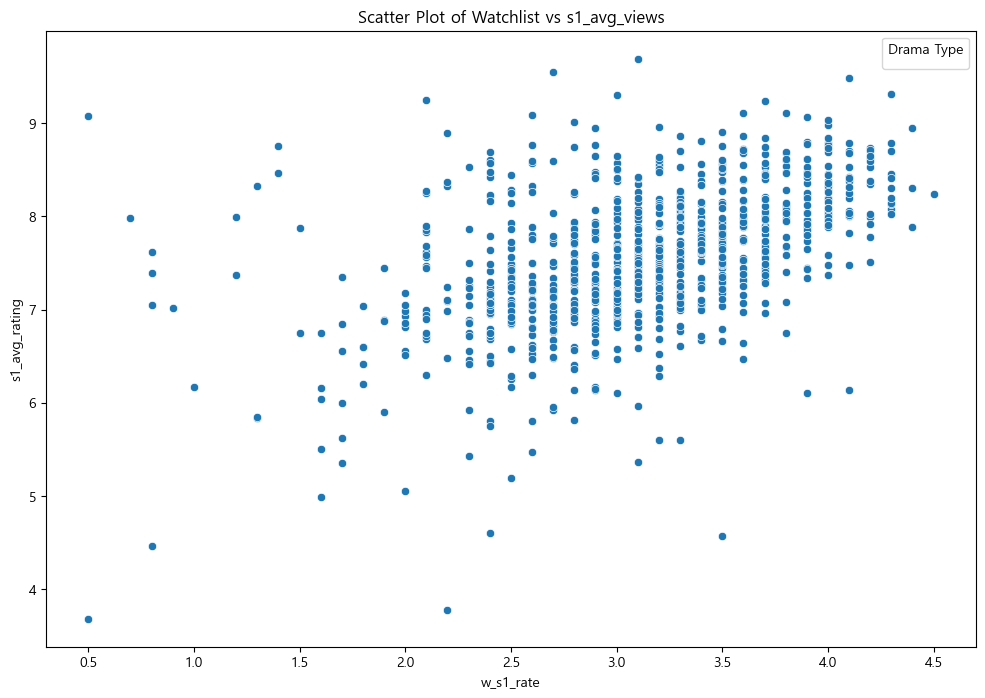

In [ ]:
# 그래프 생성
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='w_s1_rate', y='s1_avg_rating')
plt.title('Scatter Plot of Watchlist vs s1_avg_views')
plt.xlabel('w_s1_rate')
plt.ylabel('s1_avg_rating')
plt.legend(title='Drama Type')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


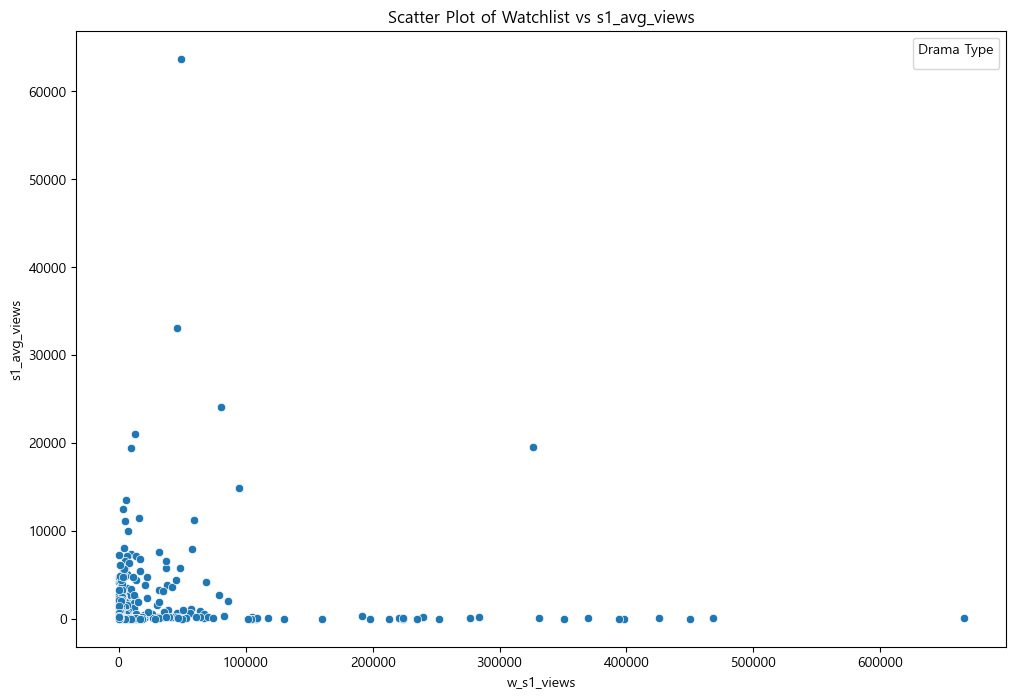

In [ ]:
# 그래프 생성
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='w_s1_views', y='s1_avg_views')
plt.title('Scatter Plot of Watchlist vs s1_avg_views')
plt.xlabel('w_s1_views')
plt.ylabel('s1_avg_views')
plt.legend(title='Drama Type')
plt.show()

In [ ]:
df[df['s1_avg_views'] >= 50000]

,korean_title,english_title,year,s1_avg_rating,s1_avg_views,s1_retention_rate,term,season_1,w_s1_rate,w_s1_views,w_s1_reviews
46,블랙 미러,Black Mirror,2011,8.033333,63666.666667,103.174603,2,"[4.0, 49000, 1500]",4.0,49000,1500


In [ ]:
df[df['w_s1_views'] >= 500000]

,korean_title,english_title,year,s1_avg_rating,s1_avg_views,s1_retention_rate,term,season_1,w_s1_rate,w_s1_views,w_s1_reviews
606,SKY 캐슬,SKY Castle,2018,7.775,50.3,58.75,2,"[4.2, 666000, 4000]",4.2,666000,4000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   korean_title       906 non-null    object 
 1   english_title      906 non-null    object 
 2   year               906 non-null    int64  
 3   s1_avg_rating      906 non-null    float64
 4   s1_avg_views       906 non-null    float64
 5   s1_retention_rate  906 non-null    float64
 6   term               906 non-null    int64  
 7   season_1           906 non-null    object 
 8   w_s1_rate          906 non-null    float64
 9   w_s1_views         906 non-null    int64  
 10  w_s1_reviews       906 non-null    int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 78.0+ KB


In [ ]:
# success_metric을 기준으로 내림차순 정렬
sorted_df = df.sort_values(by='success_metric', ascending=False)

# 상위 30개 작품 출력 (title 대신 korean_title 사용)
top_30 = sorted_df[['korean_title', 'success_metric']].head(30)

# 결과 출력
print(top_30)

                 korean_title  success_metric
606                    SKY 캐슬   665990.333710
338                  별에서 온 그대   467981.256040
196                      청춘시대   449988.059786
260                  힘쎈여자 도봉순   425982.568365
174                  동백꽃 필 무렵   397998.585908
663                    멜로가 체질   394006.086719
386                    부부의 세계   369993.765606
460                   뷰티 인사이드   350986.671771
159            달의 연인 - 보보경심 려   330993.114065
7                       워킹 데드   326305.077580
132                 응답하라 1988   284007.483508
268                      상속자들   276990.927913
518                아름다웠던 우리에게   251992.494864
34                        시그널   240017.675618
896                   성균관 스캔들   234989.778214
337                        미생   224001.734096
529               내 아이디는 강남미인   223991.146096
314                 푸른 바다의 전설   220993.279625
32                       언내추럴   213006.044029
479                    눈이 부시게   198002.978501
93                        도깨비   19

In [ ]:
# success_metric을 기준으로 내림차순 정렬
sorted_df = df.sort_values(by='success_metric', ascending=True)

# 상위 30개 작품 출력 (title 대신 korean_title 사용)
top_30 = sorted_df[['korean_title', 'success_metric']].head(30)

# 결과 출력
print(top_30)

     korean_title  success_metric
819           케이지        1.110165
120         컨트리 퀸        1.123429
801        새비지 리듬        1.141580
687        여름의 비밀        2.151650
682        타임 허슬러        2.170418
827          #노필터        2.190045
785          매버릭스        2.198948
798     스트레인지 스토리        2.282768
814          파나티코        2.284941
527           피드백        2.566974
228    앗! 크리스마스라니        3.138232
867           CAT        3.162325
829  잃어버린 올라를 찾아서        3.307404
672        위기의 명절        3.382952
712            뤼딕        3.412244
904            달러        3.487830
789      아날로그 스쿼드        3.522684
738         멈춘 남자        3.650140
779        위살 패밀리        3.883914
810            마이        4.220973
365      인생은 오답노트        4.232656
641            특종        4.261492
227           인퍼미        4.277498
754          티후아나        4.291649
124       챔피언의 비트        4.357233
796         섄티 타운        4.455261
780  니키 잼: 엘 가나도르        4.586520
903       킬러 코미디언        4.655661
764   리부트: 가디언

{'s1_avg_rating': 2.480845685635841e-06, 's1_avg_views': 0.00419568287638328, 's1_min_rating': 2.2210439958418377e-06, 's1_min_views': 0.0036751770438048863, 's1_max_rating': 2.969236243505065e-06, 's1_max_views': 0.005888080419502197, 's1_retention_rate': -1.457390682528991e-05, 'term': 3.636419232033335e-06, 'w_s1_rate': 4.008214629047992e-06, 'w_s1_views': 0.9999400744517597, 'w_s1_reviews': 0.007353031462455051}
                 korean_title  success_metric
606                    SKY 캐슬   665990.333710
338                  별에서 온 그대   467981.256040
196                      청춘시대   449988.059786
260                  힘쎈여자 도봉순   425982.568365
174                  동백꽃 필 무렵   397998.585908
663                    멜로가 체질   394006.086719
386                    부부의 세계   369993.765606
460                   뷰티 인사이드   350986.671771
159            달의 연인 - 보보경심 려   330993.114065
7                       워킹 데드   326305.077580
132                 응답하라 1988   284007.483508
268                      상속자

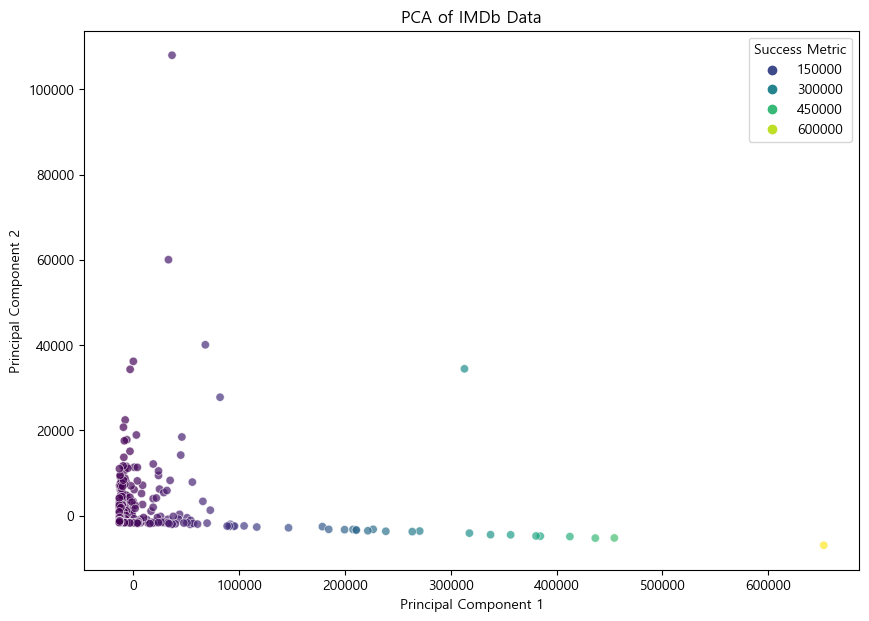

In [ ]:
# PCA를 위한 데이터 준비
metrics_df = pd.DataFrame()
metrics_df['s1_avg_rating'] = df['s1_avg_rating']
metrics_df['s1_avg_views'] = df['s1_avg_views']
metrics_df['s1_min_rating'] = df['s1_min_rating']
metrics_df['s1_min_views'] = df['s1_min_views']
metrics_df['s1_max_rating'] = df['s1_max_rating']
metrics_df['s1_max_views'] = df['s1_max_views']
metrics_df['s1_retention_rate'] = df['s1_retention_rate']
metrics_df['term'] = df['term']
metrics_df['w_s1_rate'] = df['w_s1_rate']
metrics_df['w_s1_views'] = df['w_s1_views']
metrics_df['w_s1_reviews'] = df['w_s1_reviews']

# PCA 적용
pca = PCA(n_components=2)
principal_components = pca.fit_transform(metrics_df)

# PCA 결과를 데이터프레임에 추가
df['PC1'] = principal_components[:, 0]
df['PC2'] = principal_components[:, 1]

# PCA에서 추출한 주성분 가중치
pca_weights = pca.components_[0]

# 가중치 딕셔너리 생성
weights = {
    's1_avg_rating': pca_weights[0],
    's1_avg_views': pca_weights[1],
    's1_min_rating': pca_weights[2],
    's1_min_views': pca_weights[3],
    's1_max_rating': pca_weights[4],
    's1_max_views': pca_weights[5],
    's1_retention_rate': pca_weights[6],
    'term': pca_weights[7],
    'w_s1_rate': pca_weights[8],
    'w_s1_views': pca_weights[9],
    'w_s1_reviews': pca_weights[10]
}

print(weights)

# 흥행지표 계산 함수
def calculate_success_metric(row, weights):
    # 종합 흥행지표 계산
    metric = (
        weights['s1_avg_rating'] * row['s1_avg_rating'] +
        weights['s1_avg_views'] * row['s1_avg_views'] +
        weights['s1_min_rating'] * row['s1_min_rating'] +
        weights['s1_min_views'] * row['s1_min_views'] +
        weights['s1_max_rating'] * row['s1_max_rating'] +
        weights['s1_max_views'] * row['s1_max_views'] +
        weights['s1_retention_rate'] * row['s1_retention_rate'] +
        weights['term'] * row['term'] +
        weights['w_s1_rate'] * row['w_s1_rate'] +
        weights['w_s1_views'] * row['w_s1_views'] +
        weights['w_s1_reviews'] * row['w_s1_reviews']
    )
    return metric

# 흥행지표 계산 및 결과 출력
df['success_metric'] = df.apply(lambda row: calculate_success_metric(row, weights), axis=1)

# success_metric을 기준으로 내림차순 정렬
sorted_df = df.sort_values(by='success_metric', ascending=False)

# 상위 30개 작품 출력 (korean_title 사용)
top_30 = sorted_df[['korean_title', 'success_metric']].head(30)

# 결과 출력
print(top_30)

# 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='success_metric', palette='viridis', alpha=0.7)
plt.title('PCA of IMDb Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Success Metric')
plt.show()

Index(['korean_title', 'english_title', 'year', 's1_avg_rating',
       's1_avg_views', 's1_min_rating', 's1_min_views', 's1_max_rating',
       's1_max_views', 's1_retention_rate', 'term', 'season_1', 'w_s1_rate',
       'w_s1_views', 'w_s1_reviews', 'success_metric', 'PC1', 'PC2'],
      dtype='object')
{'s1_avg_rating': 2.480845685635837e-06, 's1_avg_views': 0.004195682876383292, 's1_min_rating': 2.221043995841762e-06, 's1_min_views': 0.0036751770438049, 's1_max_rating': 2.9692362435050804e-06, 's1_max_views': 0.00588808041950222, 's1_retention_rate': -1.4573906825289904e-05, 'term': 3.6364192320333383e-06, 'w_s1_rate': 4.008214629047996e-06, 'w_s1_views': 0.9999400744517599, 'w_s1_reviews': 0.007353031462455053}
                 korean_title  success_metric
606                    SKY 캐슬   665990.333710
338                  별에서 온 그대   467981.256040
196                      청춘시대   449988.059786
260                  힘쎈여자 도봉순   425982.568365
174                  동백꽃 필 무렵   397998.58590

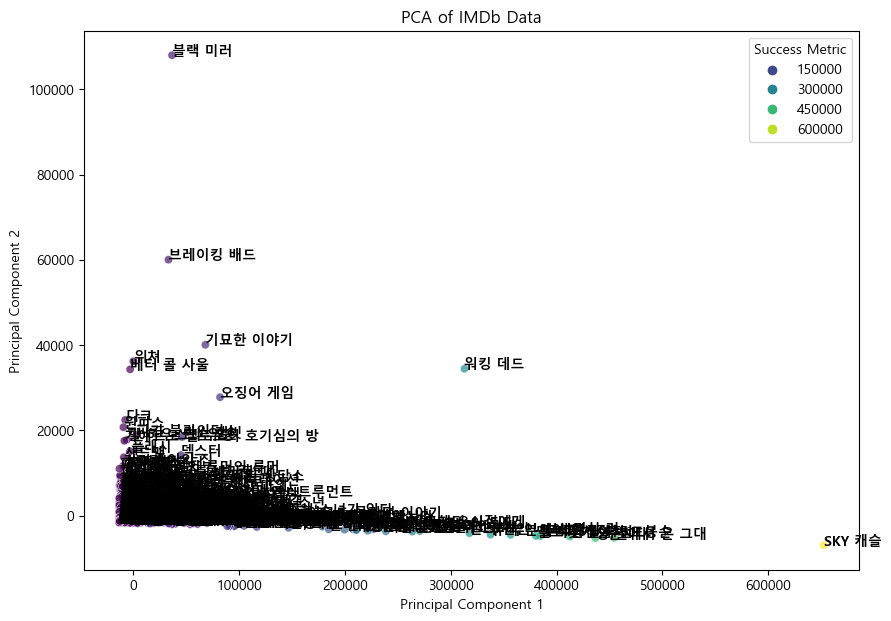

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 예시 데이터프레임 생성 (원본 데이터프레임 df가 이미 있다고 가정)
# df = pd.read_csv('your_dataframe.csv') # 실제 데이터프레임을 로드하는 코드 필요

# 데이터프레임의 열 이름 출력
print(df.columns)

# PCA를 위한 데이터 준비
metrics_df = pd.DataFrame()
metrics_df['s1_avg_rating'] = df['s1_avg_rating']
metrics_df['s1_avg_views'] = df['s1_avg_views']
metrics_df['s1_min_rating'] = df['s1_min_rating']
metrics_df['s1_min_views'] = df['s1_min_views']
metrics_df['s1_max_rating'] = df['s1_max_rating']
metrics_df['s1_max_views'] = df['s1_max_views']
metrics_df['s1_retention_rate'] = df['s1_retention_rate']
metrics_df['term'] = df['term']
metrics_df['w_s1_rate'] = df['w_s1_rate']
metrics_df['w_s1_views'] = df['w_s1_views']
metrics_df['w_s1_reviews'] = df['w_s1_reviews']

# PCA 적용
pca = PCA(n_components=2)
principal_components = pca.fit_transform(metrics_df)

# PCA 결과를 데이터프레임에 추가
df['PC1'] = principal_components[:, 0]
df['PC2'] = principal_components[:, 1]

# PCA에서 추출한 주성분 가중치
pca_weights = pca.components_[0]

# 가중치 딕셔너리 생성
weights = {
    's1_avg_rating': pca_weights[0],
    's1_avg_views': pca_weights[1],
    's1_min_rating': pca_weights[2],
    's1_min_views': pca_weights[3],
    's1_max_rating': pca_weights[4],
    's1_max_views': pca_weights[5],
    's1_retention_rate': pca_weights[6],
    'term': pca_weights[7],
    'w_s1_rate': pca_weights[8],
    'w_s1_views': pca_weights[9],
    'w_s1_reviews': pca_weights[10]
}

print(weights)

# 흥행지표 계산 함수
def calculate_success_metric(row, weights):
    # 종합 흥행지표 계산
    metric = (
        weights['s1_avg_rating'] * row['s1_avg_rating'] +
        weights['s1_avg_views'] * row['s1_avg_views'] +
        weights['s1_min_rating'] * row['s1_min_rating'] +
        weights['s1_min_views'] * row['s1_min_views'] +
        weights['s1_max_rating'] * row['s1_max_rating'] +
        weights['s1_max_views'] * row['s1_max_views'] +
        weights['s1_retention_rate'] * row['s1_retention_rate'] +
        weights['term'] * row['term'] +
        weights['w_s1_rate'] * row['w_s1_rate'] +
        weights['w_s1_views'] * row['w_s1_views'] +
        weights['w_s1_reviews'] * row['w_s1_reviews']
    )
    return metric

# 흥행지표 계산 및 결과 출력
df['success_metric'] = df.apply(lambda row: calculate_success_metric(row, weights), axis=1)

# success_metric을 기준으로 내림차순 정렬
sorted_df = df.sort_values(by='success_metric', ascending=False)

# 상위 30개 작품 출력 (korean_title 사용)
top_30 = sorted_df[['korean_title', 'success_metric']].head(30)

# 결과 출력
print(top_30)

# 시각화
plt.figure(figsize=(10, 7))
scatterplot = sns.scatterplot(data=df, x='PC1', y='PC2', hue='success_metric', palette='viridis', alpha=0.7)

# 각 점에 korean_title 표시
for line in range(0, df.shape[0]):
    scatterplot.text(df.PC1[line], df.PC2[line], df.korean_title[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title('PCA of IMDb Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Success Metric')
plt.show()


C:\Users\rbfl7\AppData\Local\Temp\ipykernel_13172\1352029122.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x='PC1', y='PC2', palette='viridis', alpha=0.7)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


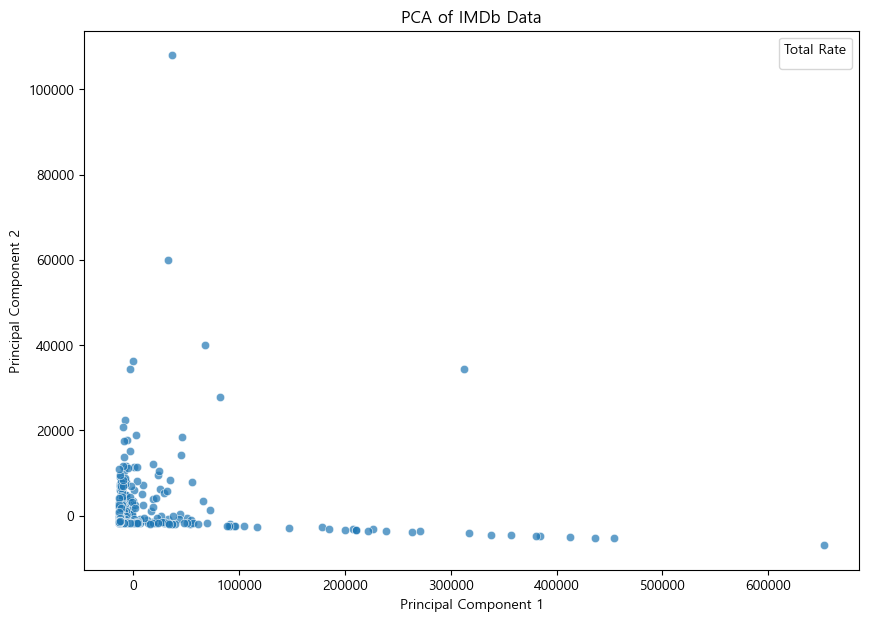

In [ ]:
# 시각화
# 주성분 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='PC1', y='PC2', palette='viridis', alpha=0.7)
plt.title('PCA of IMDb Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Total Rate')
plt.show()